# Trends in Urban Heat Island Strength Across Major US Cities

### Load Data

In [29]:
# Setup
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
import pymannkendall as mk
from scipy.stats import pearsonr, spearmanr



In [ ]:
file_path = "/Users/Haley/atms523/ATMS-523-Module-8-Project/data_stream-moda.nc"

ds = xr.open_dataset(
    file_path,
    engine="netcdf4"
)

# rename 
ds = ds.rename({"t2m": "Tmean"})
ds = ds.rename({"valid_time":"time"})

print(ds)

<xarray.Dataset> Size: 108MB
Dimensions:     (valid_time: 225, latitude: 211, longitude: 571)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 2kB 1950-06-01 ... 2024-08-01
  * latitude    (latitude) float64 2kB 51.0 50.9 50.8 50.7 ... 30.2 30.1 30.0
  * longitude   (longitude) float64 5kB -126.5 -126.4 -126.3 ... -69.6 -69.5
    expver      (valid_time) <U4 4kB ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 108MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-12-06T21:17 GRIB to CDM+CF via cfgrib-0.9.1...


### City Boundaries

In [ ]:
CITIES = {
    "New_York_City": {
        "lat_min": 38.7,
        "lat_max": 42.7,
        "lon_min": -76.5,
        "lon_max": -71.5,
    },
    "Chicago": {
        "lat_min": 40.0,
        "lat_max": 43.0,
        "lon_min": -89.5,
        "lon_max": -85.5,
    },
    "Los_Angeles": {
        "lat_min": 32.0,
        "lat_max": 35.0,
        "lon_min": -120.5,
        "lon_max": -116.5,
    },
    "Atlanta": {
        "lat_min": 32.5,
        "lat_max": 35.5,
        "lon_min": -86.5,
        "lon_max": -82.5,
    },
    "Seattle": {
        "lat_min": 46.0,
        "lat_max": 49.0,
        "lon_min": -124.5,
        "lon_max": -120.5,
    },
}

# Expansion degree for rural areas
RURAL_EXPANSION_DEG = 3.0  

# baseline years
BASE_START = 1981 
BASE_END = 2010

### Monthly Mean Temperatures

In [35]:
# Function to compute monthly regional mean temperatures for urban and rural 
def compute_city_monthly_Tmean(ds,cities_dict,rural_expansion_deg=2.0,):
    lon_data_min = float(ds.longitude.min())
    out = []

    for city_name, cfg in cities_dict.items():
        print(f"Processing city: {city_name}")

        lat_min, lat_max = cfg["lat_min"], cfg["lat_max"]
        lon_min, lon_max = cfg["lon_min"], cfg["lon_max"]

        lon_min_ds, lon_max_ds = lon_min, lon_max

        # Expanded box for rural area
        lat_min_ext = lat_min - rural_expansion_deg
        lat_max_ext = lat_max + rural_expansion_deg
        lon_min_ext = lon_min_ds - rural_expansion_deg
        lon_max_ext = lon_max_ds + rural_expansion_deg

        # Latitude is probably descending (e.g., 51 → 30) in ERA5-Land
        lat0 = ds.latitude[0].item()
        lat_last = ds.latitude[-1].item()
        if lat0 > lat_last:
            lat_slice_ext = slice(lat_max_ext, lat_min_ext)
        else:
            lat_slice_ext = slice(lat_min_ext, lat_max_ext)

        lon_slice_ext = slice(lon_min_ext, lon_max_ext)

        # Subset to expanded box
        ds_box = ds.sel(latitude=lat_slice_ext, longitude=lon_slice_ext)

        # Build urban mask 
        city_lat_min, city_lat_max = sorted([lat_min, lat_max])
        city_lon_min, city_lon_max = lon_min_ds, lon_max_ds

        urban_mask = (
            (ds_box.latitude >= city_lat_min) &
            (ds_box.latitude <= city_lat_max) &
            (ds_box.longitude >= city_lon_min) &
            (ds_box.longitude <= city_lon_max)
        )
        rural_mask = ~urban_mask

        def simple_mean(da, mask):
            return da.where(mask).mean(dim=("latitude", "longitude"))

        urb_T = simple_mean(ds_box["Tmean"], urban_mask)
        rur_T = simple_mean(ds_box["Tmean"], rural_mask)

        out.append(
            xr.Dataset(
                {
                    "urban_Tmean": urb_T,
                    "rural_Tmean": rur_T,
                }
            ).assign_coords(city=city_name)
        )

    ds_out = xr.concat(out, dim="city")
    return ds_out


ds_city_monthly = compute_city_monthly_Tmean(
    ds,
    CITIES,
    rural_expansion_deg=RURAL_EXPANSION_DEG,
)

print(ds_city_monthly)



Processing city: New_York_City
Processing city: Chicago
Processing city: Los_Angeles
Processing city: Atlanta
Processing city: Seattle
<xarray.Dataset> Size: 15kB
Dimensions:      (city: 5, time: 225)
Coordinates:
    number       int64 8B 0
  * time         (time) datetime64[ns] 2kB 1950-06-01 1950-07-01 ... 2024-08-01
    expver       (time) <U4 4kB '0001' '0001' '0001' ... '0001' '0001' '0001'
  * city         (city) <U13 260B 'New_York_City' 'Chicago' ... 'Seattle'
Data variables:
    urban_Tmean  (city, time) float32 4kB 291.9 294.2 293.6 ... 291.4 289.7
    rural_Tmean  (city, time) float32 4kB 291.6 293.4 292.9 ... 294.5 291.8


In [ ]:
# Aggregate to annual JJA mean temperatures

# Group by year 
ds_city_annual = ds_city_monthly.groupby("time.year").mean("time")
ds_city_annual = ds_city_annual.rename({"year": "year"})

print(ds_city_annual)

<xarray.Dataset> Size: 4kB
Dimensions:      (year: 75, city: 5)
Coordinates:
    number       int64 8B 0
  * city         (city) <U13 260B 'New_York_City' 'Chicago' ... 'Seattle'
  * year         (year) int64 600B 1950 1951 1952 1953 ... 2021 2022 2023 2024
Data variables:
    urban_Tmean  (year, city) float32 2kB 293.2 293.7 295.8 ... 299.0 288.8
    rural_Tmean  (year, city) float32 2kB 292.7 293.7 300.0 ... 299.2 290.6
NYC JJA mean Tmean (K) per year:
<xarray.DataArray 'urban_Tmean' (year: 75)> Size: 300B
array([293.2189 , 293.37387, 294.63803, 294.27774, 293.4979 , 295.02884,
       293.34982, 294.11343, 293.1633 , 294.5457 , 293.5697 , 293.84604,
       293.68066, 293.59607, 293.4028 , 293.4985 , 294.8359 , 293.75058,
       294.157  , 293.81802, 294.09213, 293.91162, 292.7072 , 294.88895,
       293.76096, 294.2123 , 293.87512, 293.8473 , 293.8132 , 293.5419 ,
       294.45972, 294.19824, 292.82156, 294.8176 , 294.0239 , 293.19772,
       293.35654, 294.59903, 295.06937, 293.6810

### 95th Percentile Thresholds

In [ ]:
# compute 95th percentile thresholds for baseline years

def compute_jja_percentile_thresholds_all_years(ds_annual,base_start,base_end,percentile=95,):

    ds_base = ds_annual.sel(year=slice(base_start, base_end))

    q = percentile / 100.0

    urban_thresh = ds_base["urban_Tmean"].quantile(q, dim="year", skipna=True)
    rural_thresh = ds_base["rural_Tmean"].quantile(q, dim="year", skipna=True)

    thresholds = xr.Dataset(
        {
            "urban_thresh": urban_thresh,
            "rural_thresh": rural_thresh,
        }
    )

    return thresholds


thresholds_95 = compute_jja_percentile_thresholds_all_years(
    ds_city_annual,
    base_start=BASE_START,
    base_end=BASE_END,
    percentile=95,
)

print(thresholds_95)



<xarray.Dataset> Size: 348B
Dimensions:       (city: 5)
Coordinates:
  * city          (city) <U13 260B 'New_York_City' 'Chicago' ... 'Seattle'
    quantile      float64 8B 0.95
Data variables:
    urban_thresh  (city) float64 40B 295.5 296.9 297.6 299.3 289.1
    rural_thresh  (city) float64 40B 294.8 296.8 301.8 299.6 290.6


In [ ]:
# Find extreme years (mean > 95th percentile)
urban_thresh = thresholds_95["urban_thresh"]  
rural_thresh = thresholds_95["rural_thresh"] 

urban_exceed = ds_city_annual["urban_Tmean"] > urban_thresh
rural_exceed = ds_city_annual["rural_Tmean"] > rural_thresh

urban_extreme_year = urban_exceed.astype(int)
rural_extreme_year = rural_exceed.astype(int)

print("Urban extreme-year flags (1=extreme):")
print(urban_extreme_year)


Urban extreme-year flags (1=extreme):
<xarray.DataArray (year: 75, city: 5)> Size: 3kB
array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
...
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [1, 0, 1, 1, 0],
       [0, 0, 1, 0, 1],
       [0, 0, 1, 0, 1],
       [0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 1],
       [0, 0, 1, 0, 1

### Compute UHI Index

In [ ]:
# UHI index based on JJA mean 
uhi_JJA = ds_city_annual["urban_Tmean"] - ds_city_annual["rural_Tmean"]

def stl_decompose_annual(series, period=15):
    s = series.dropna("year").to_pandas()
    stl = STL(s, period=period, robust=True)
    result = stl.fit()
    return result

nyc_uhi = uhi_JJA.sel(city="New_York_City")
nyc_uhi_stl = stl_decompose_annual(nyc_uhi, period=15)

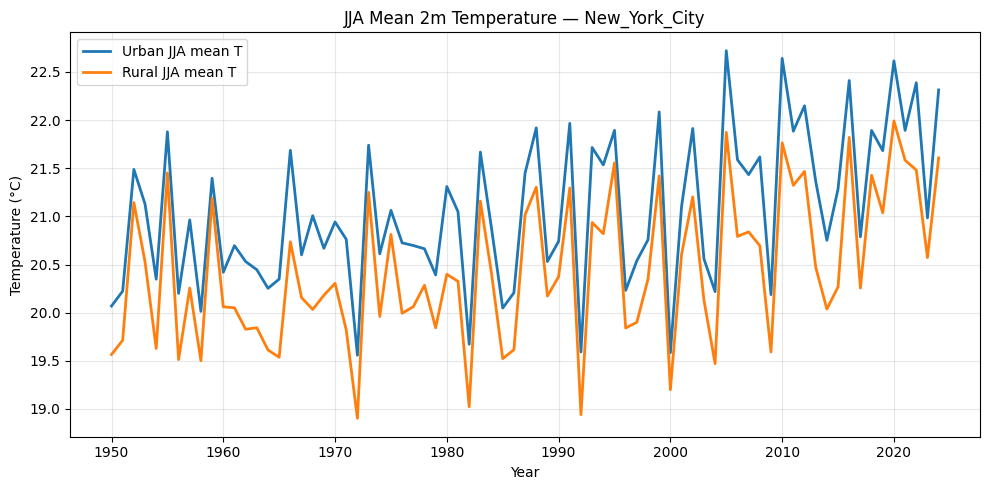

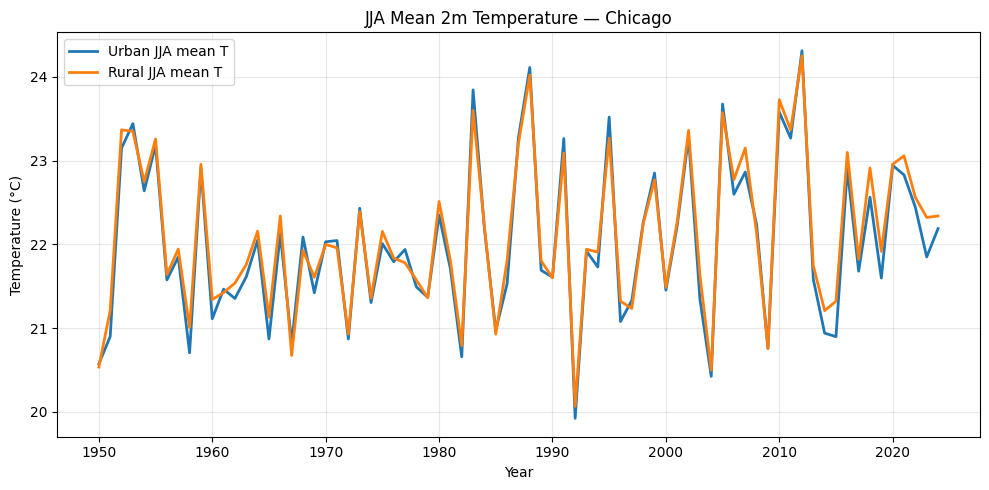

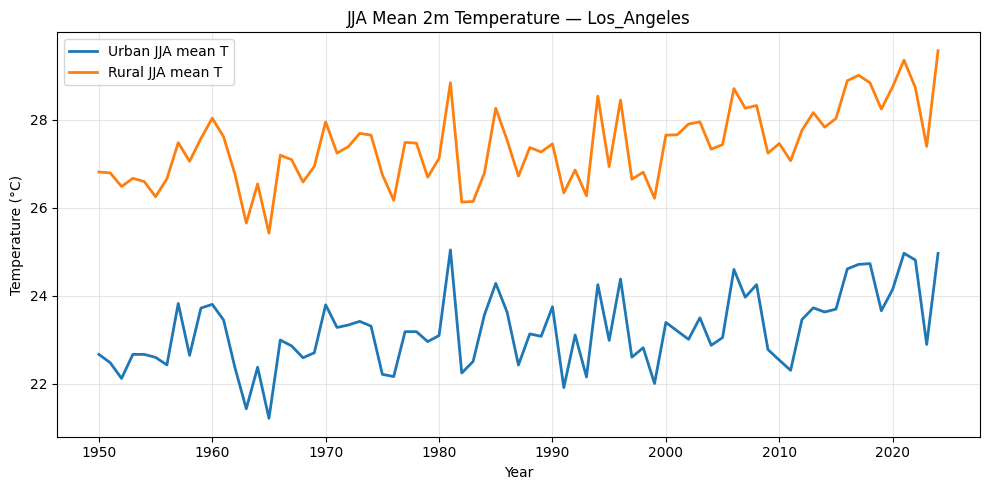

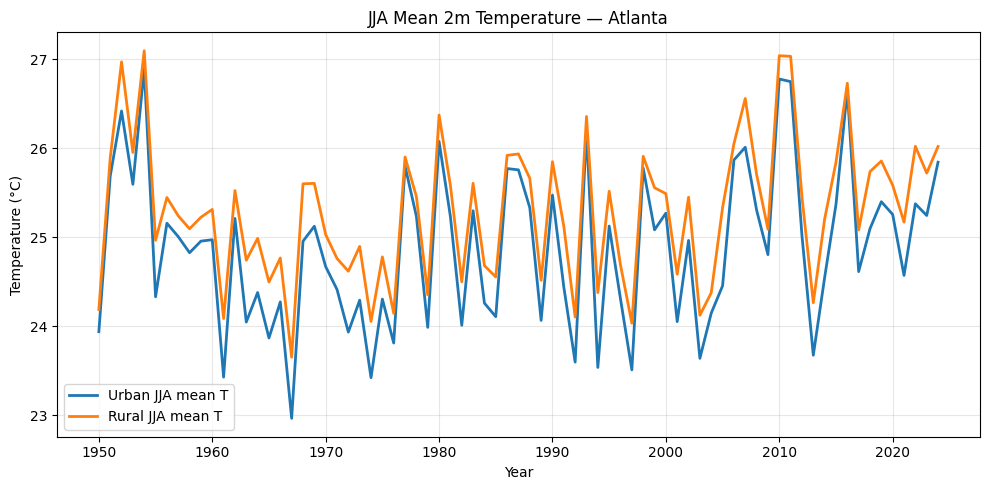

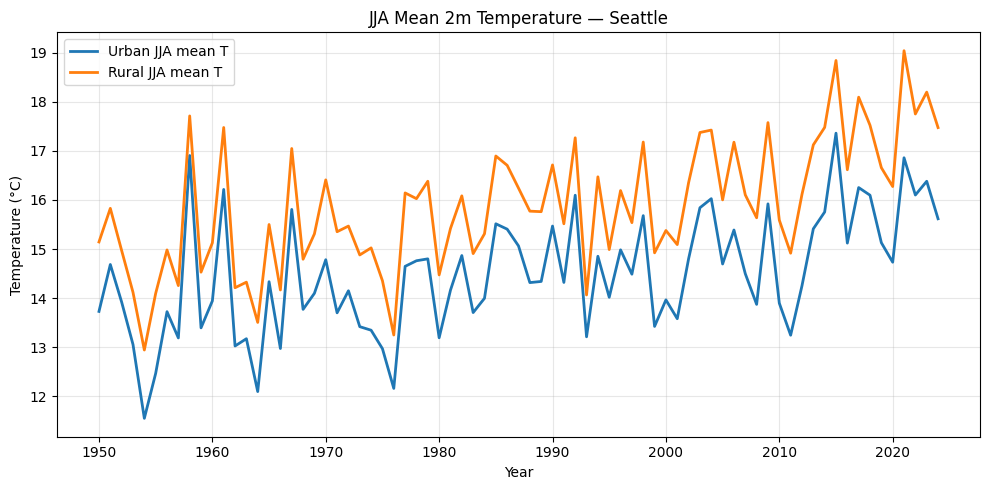

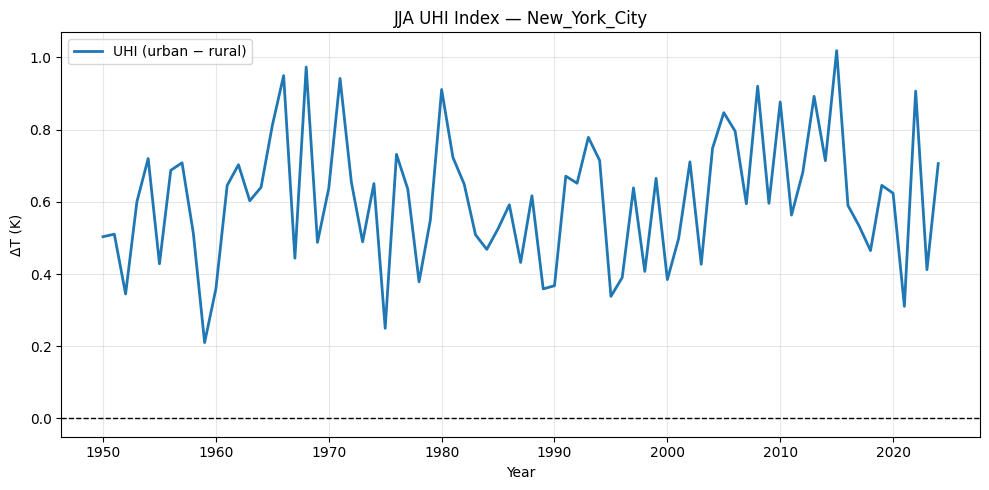

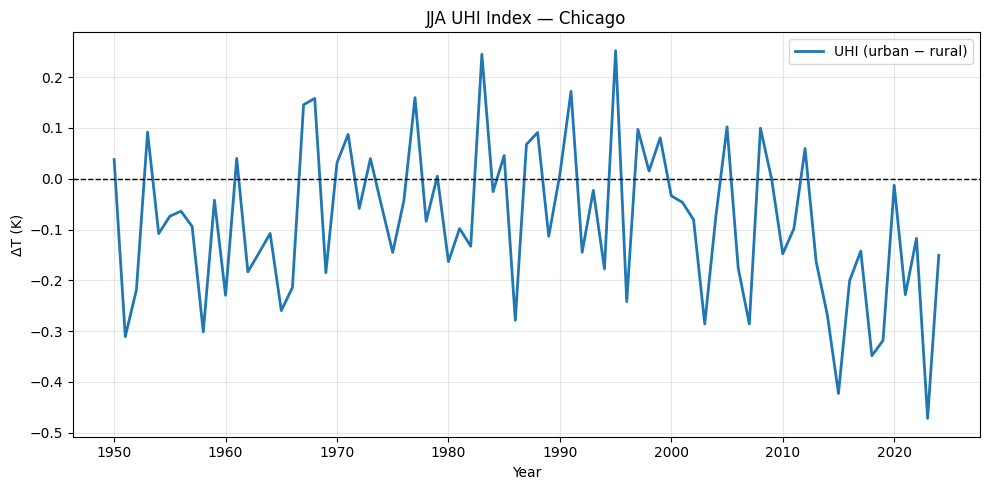

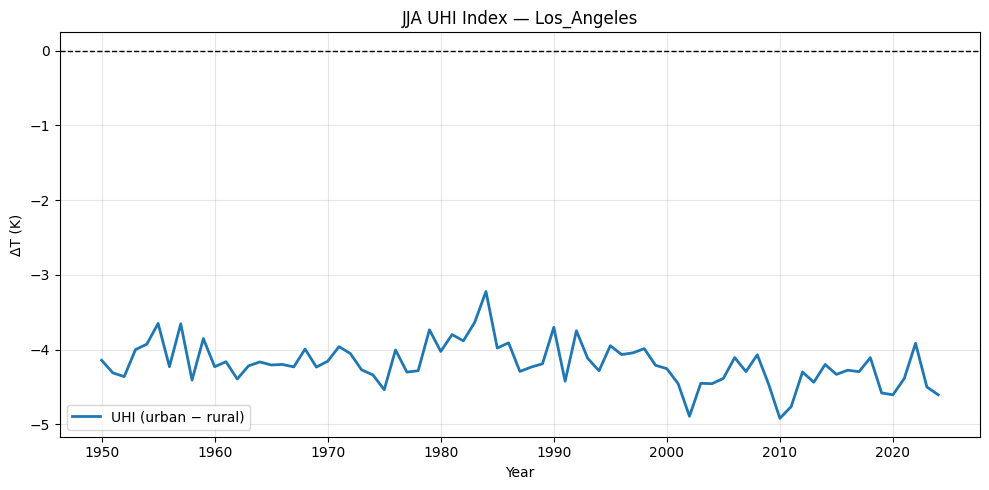

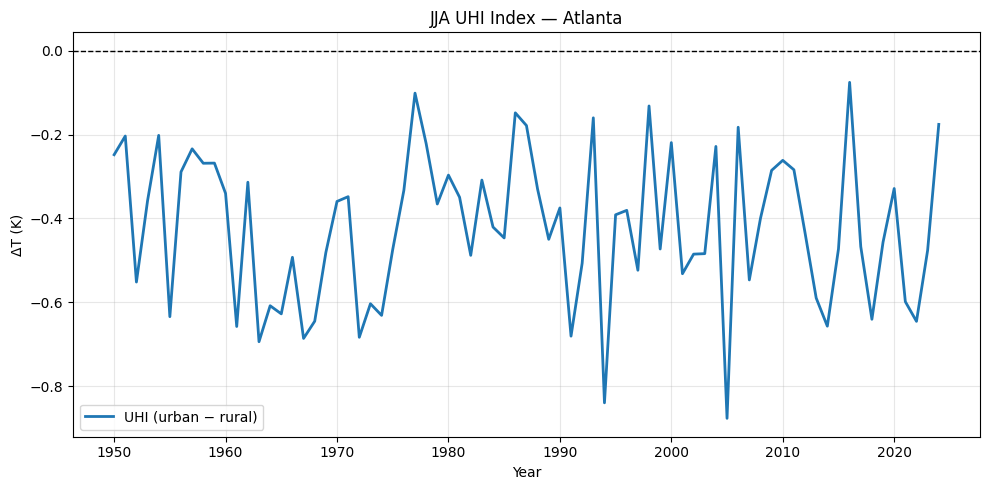

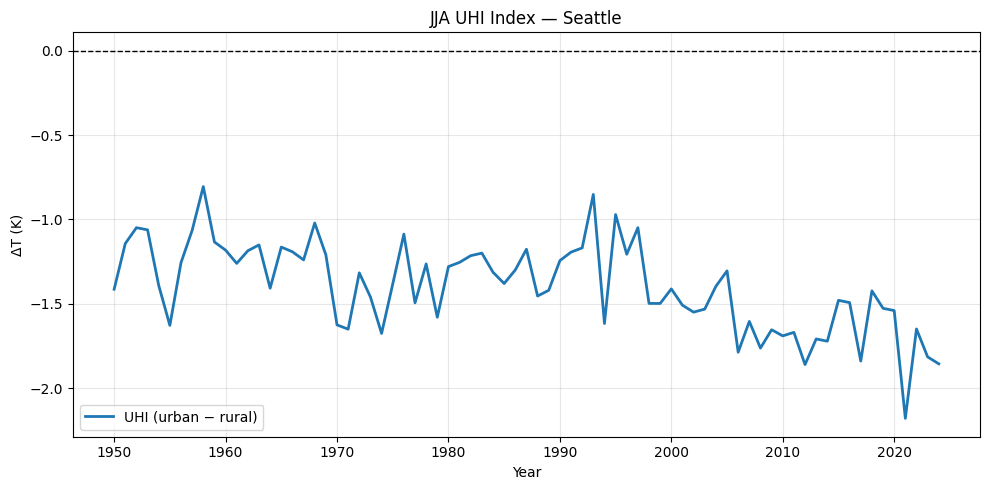

In [ ]:
# Plot Time series of jja means
def plot_jja_mean_Tmean_urban_rural(ds_annual):
    for city in ds_annual.city.values:
        urb = ds_annual["urban_Tmean"].sel(city=city).to_pandas() - 273.15
        rur = ds_annual["rural_Tmean"].sel(city=city).to_pandas() - 273.15

        plt.figure(figsize=(10,5))
        plt.plot(urb.index, urb.values, label="Urban JJA mean T", linewidth=2)
        plt.plot(rur.index, rur.values, label="Rural JJA mean T", linewidth=2)

        plt.title(f"JJA Mean 2m Temperature — {city}")
        plt.xlabel("Year")
        plt.ylabel("Temperature (°C)")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()

# plot UHI index
def plot_uhi_index(uhi_ds):
    for city in uhi_ds.city.values:
        series = uhi_ds.sel(city=city).to_pandas()

        plt.figure(figsize=(10,5))
        plt.plot(series.index, series.values, label="UHI (urban - rural)", linewidth=2)

        plt.axhline(0.0, color="k", linewidth=1, linestyle="--")
        plt.title(f"JJA UHI Index — {city}")
        plt.xlabel("Year")
        plt.ylabel("ΔT (K)")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()


plot_jja_mean_Tmean_urban_rural(ds_city_annual)
plot_uhi_index(uhi_JJA)

### Trend Statistics

In [ ]:
# Compute Mann-kendall and sens slope
def compute_trend_stats(ds_annual):

    results = []

    for city in ds_annual.city.values:
        urb = ds_annual["urban_Tmean"].sel(city=city).to_pandas()
        rur = ds_annual["rural_Tmean"].sel(city=city).to_pandas()
        uhi = urb - rur

        urb = urb.dropna()
        rur = rur.dropna()
        uhi = uhi.dropna()

        # Mann–Kendall
        mk_urb = mk.original_test(urb.values)
        mk_rur = mk.original_test(rur.values)
        mk_uhi = mk.original_test(uhi.values)

        # Sen slope 
        slope_urb = mk_urb.slope * 10
        slope_rur = mk_rur.slope * 10
        slope_uhi = mk_uhi.slope * 10

        results.append({
            "city": city,
            "urban_trend_K_per_decade": slope_urb,
            "urban_p_value": mk_urb.p,
            "rural_trend_K_per_decade": slope_rur,
            "rural_p_value": mk_rur.p,
            "uhi_trend_K_per_decade": slope_uhi,
            "uhi_p_value": mk_uhi.p,
        })

    return pd.DataFrame(results).set_index("city")


trend_table = compute_trend_stats(ds_city_annual)

trend_table


,urban_trend_K_per_decade,urban_p_value,rural_trend_K_per_decade,rural_p_value,uhi_trend_K_per_decade,uhi_p_value
city,,,,,,
New_York_City,0.177881,5.060329e-05,0.165075,4.866001e-05,0.010981,2.927595e-01
Chicago,0.086353,9.774333e-02,0.105257,5.133741e-02,-0.011999,1.939100e-01
Los_Angeles,0.186631,6.641317e-05,0.236631,2.725471e-07,-0.043909,1.201183e-03
Atlanta,0.063194,9.590430e-02,0.075109,7.592672e-02,-0.006189,6.672077e-01
Seattle,0.323827,4.634200e-07,0.390885,1.201113e-08,-0.076814,1.201113e-08


### Compare Early vs Late Periods

In [ ]:
EARLY_START = 1950
EARLY_END   = 1979

LATE_START  = 1995
LATE_END    = 2024

def compute_period_means(ds_annual, start_year, end_year):
    return ds_annual.sel(year=slice(start_year, end_year)).mean("year")

early_means = compute_period_means(ds_city_annual, EARLY_START, EARLY_END)
late_means  = compute_period_means(ds_city_annual, LATE_START, LATE_END)

early_uhi = early_means["urban_Tmean"] - early_means["rural_Tmean"]
late_uhi  = late_means["urban_Tmean"] - late_means["rural_Tmean"]


In [27]:
summary = []

for city in ds_city_annual.city.values:
    summary.append({
        "city": city,
        "urban_JJA_early_K": float(early_means["urban_Tmean"].sel(city=city)),
        "urban_JJA_late_K":  float(late_means["urban_Tmean"].sel(city=city)),
        "rural_JJA_early_K": float(early_means["rural_Tmean"].sel(city=city)),
        "rural_JJA_late_K":  float(late_means["rural_Tmean"].sel(city=city)),
        "uhi_early_K":       float(early_uhi.sel(city=city)),
        "uhi_late_K":        float(late_uhi.sel(city=city)),
        "uhi_change_K":      float(late_uhi.sel(city=city) - early_uhi.sel(city=city)),
    })

summary_df = pd.DataFrame(summary).set_index("city")
summary_df


,urban_JJA_early_K,urban_JJA_late_K,rural_JJA_early_K,rural_JJA_late_K,uhi_early_K,uhi_late_K,uhi_change_K
city,,,,,,,
New_York_City,293.867126,294.599121,293.275055,293.969025,0.592072,0.630096,0.038025
Chicago,294.921021,295.399231,294.991882,295.519501,-0.070862,-0.120270,-0.049408
Los_Angeles,295.962189,296.755219,300.101440,301.097870,-4.139252,-4.342651,-0.203400
Atlanta,297.814728,298.234558,298.245636,298.658081,-0.430908,-0.423523,0.007385
Seattle,286.978455,288.264282,288.262146,289.837616,-1.283691,-1.573334,-0.289642


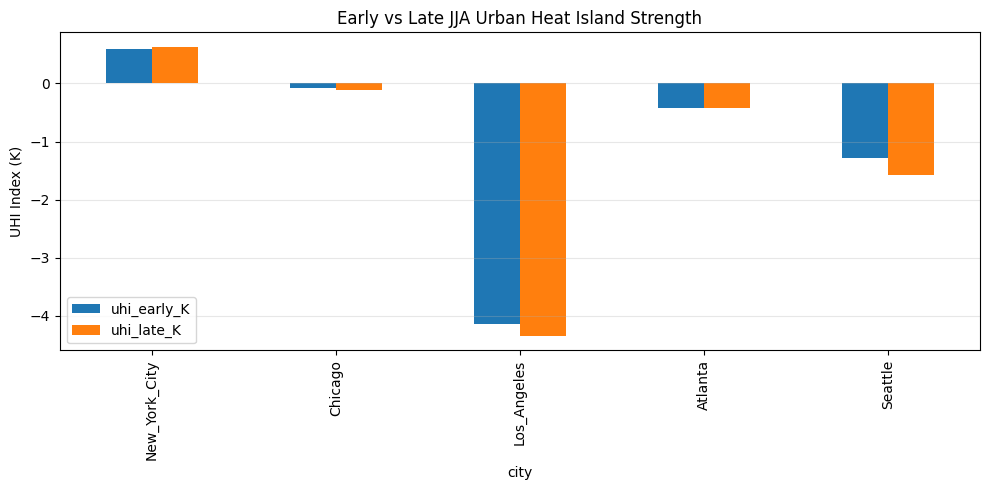

In [28]:
def plot_early_late_uhi(summary_df):
    summary_df[["uhi_early_K", "uhi_late_K"]].plot(
        kind="bar",
        figsize=(10,5)
    )
    plt.ylabel("UHI Index (K)")
    plt.title("Early vs Late JJA Urban Heat Island Strength")
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_early_late_uhi(summary_df)


### Compare UHI Trends to Population Density

In [36]:
# Population density - people/km^2
CITY_DENSITY = {
    "New_York_City": 11300,
    "Chicago": 3700,
    "Los_Angeles": 3200,
    "Atlanta": 1400,
    "Seattle": 3600,
}


In [38]:

mean_uhi = uhi_JJA.mean("year")

df_uhi_density = pd.DataFrame({
    "city": mean_uhi.city.values,
    "mean_UHI_K": mean_uhi.values,
    "population_density_km2": [
        CITY_DENSITY[city] for city in mean_uhi.city.values
    ],
}).set_index("city")

print(df_uhi_density)


               mean_UHI_K  population_density_km2
city                                             
New_York_City    0.608431                   11300
Chicago         -0.083448                    3700
Los_Angeles     -4.185173                    3200
Atlanta         -0.421531                    1400
Seattle         -1.397114                    3600


In [39]:

uhi_vals = df_uhi_density["mean_UHI_K"]
density_vals = df_uhi_density["population_density_km2"]

# Pearson correlation
r_pearson, p_pearson = pearsonr(density_vals, uhi_vals)

# Spearman correlation
r_spearman, p_spearman = spearmanr(density_vals, uhi_vals)

print(f"Pearson r = {r_pearson:.2f}, p = {p_pearson:.3f}")
print(f"Spearman = {r_spearman:.2f}, p = {p_spearman:.3f}")


Pearson r = 0.45, p = 0.445
Spearman = 0.70, p = 0.188


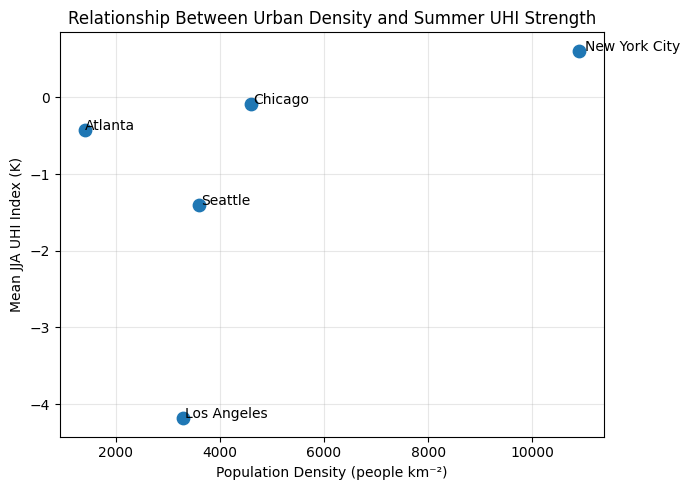

In [ ]:
# Plot
plt.figure(figsize=(7,5))
plt.scatter(density_vals, uhi_vals, s=80)

for city in df_uhi_density.index:
    plt.text(
        df_uhi_density.loc[city, "population_density_km2"] * 1.01,
        df_uhi_density.loc[city, "mean_UHI_K"],
        city.replace("_", " "),
        fontsize=10,
    )

plt.xlabel("Population Density (people km⁻²)")
plt.ylabel("Mean JJA UHI Index (K)")
plt.title("Relationship Between Urban Density and Summer UHI Strength")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
